# Figure 6

This notebook recreates the figure panels included in Figure 6 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 




## Preparing the Data
### Importing required code packages and modules

In [1]:
ls

Figure 2.ipynb      Figure 3_OLD.ipynb  Figure 5.ipynb      Supp Figures.ipynb
Figure 3.ipynb      Figure 4.ipynb      Figure 6.ipynb      utils/


In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import utils.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

from scipy.stats import zscore

Missing colon in file '/Users/sasha/.matplotlib/matplotlibrc', line 1 ('~/.matplotlib/matplotlibrc')


### downloading data

In [3]:
load_prefix = '../data/logs/SF/'

data_load_prefix = '../../data/logs/VA_maze/'
with open(data_load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
    [actions_, rewards_, feats_, terms_, vs_,
        tow_counts_, episode_lengths] = pickle.load(f)
f.close()

vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)


with open(data_load_prefix + '10K_moretrials.p', 'rb') as f:
    [_, rewards2, feats2_, _, _, tow_counts2,
        episode_lengths2] = pickle.load(f)
f.close()


feats_all = feats_ + feats2_
episode_lengths_all = np.hstack([episode_lengths, episode_lengths2])
ep_rew_all = np.hstack(
    [ep_rew, np.array([np.sum(r_trial) for r_trial in rewards2])])
ep_tow_all = np.vstack(
    [ep_tow, np.array([np.max(trial, 0) for trial in tow_counts2])])


trial_info = loadmat(data_load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names

choices = utils.extract_field(trial_info, 'choice')
trial_type = utils.extract_field(trial_info, 'trialType')
raw_ypos = utils.extract_field(trial_info, 'position')[:, 1]
cueCombos_ = utils.extract_field(trial_info, 'cueCombo')
cuePos_ = utils.extract_field(trial_info, 'cuePos')
cueOnset_ = utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:, 1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:, 0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:, 2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))])
         for x in raw_ypos_]
ypos = np.hstack(ypos_)



### Plotting Parameters

In [4]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

marker_plots =  {'marker':'.', 'markersize':2, 'markeredgecolor':'k', 'markerfacecolor':'k'}

heatmap_sz = (4, 3.5)
example_sz = (4, 1)

left_col = 'red'
right_col = 'deepskyblue'


## Get the Sensory PE
### Training the weights

In [5]:
# load directly if the weights and features were already trained 

TD_phi_trained_ = pickle.load(
    open(load_prefix + "trained_sf_pes_gamma99.p", "rb"))

In [8]:
# PART 1: TRAINING THE WEIGHTS W

# parameters for trianing

gamma = 0.99
# nb rounds in Psi and Q Learning in the same environment
num_trials = len(episode_lengths_all)
alpha = 0.001
num_feats = feats_[0].shape[1]
norm_feats_all = utils.split_by_ep_len(
    zscore(np.vstack([pes_i for pes_i in feats_all]), 0), episode_lengths_all)
feats_to_train = norm_feats_all


In [9]:

# Initialize Psi
w = np.zeros((num_feats, num_feats))
TD_phi_ = []  # np.zeros((feats_[0].shape[1], num_timesteps, num_trials))


for trial in np.arange(num_trials):
    TD_phi_tr = np.zeros((int(episode_lengths_all[trial]), num_feats))
    for ts in np.arange(int(episode_lengths_all[trial]) - 1):
        psi = w @ feats_to_train[trial][ts, :]
        psi_next = w @ feats_to_train[trial][ts + 1, :]
        TD_phi_tr[ts, :] = feats_to_train[trial][ts, :] + \
            gamma * psi_next - psi

        w = w + alpha * \
            np.outer(TD_phi_tr[ts, :], feats_to_train[trial][ts, :])
    TD_phi_.append(TD_phi_tr)


TD_phi_avg = np.vstack([np.mean(TD_phi_i, 0) for TD_phi_i in TD_phi_]).T



### Training the SF

In [10]:

# PART 2: GET SUCCESSOR FEATURES WITH THE FROZEN WEIGHTS W
num_trials = len(episode_lengths)
num_feats = feats_[0].shape[1]
TD_phi_trained_ = []


for trial in np.arange(num_trials):
    TD_phi_tr = np.zeros((int(episode_lengths_all[trial]), num_feats))

    for ts in np.arange(int(episode_lengths_all[trial]) - 1):
        psi = w @ feats_to_train[trial][ts, :]
        psi_next = w @ feats_to_train[trial][ts + 1, :]
        TD_phi_tr[ts, :] = feats_to_train[trial][ts, :] + \
            gamma * psi_next - psi
    TD_phi_trained_.append(TD_phi_tr)



### Organizing Data

Pulling out the specific data that we will use for figure panels

In [8]:
SF_ = TD_phi_trained_
CUEP_LIM = 140

SF_cuep = np.vstack([pes_i[:CUEP_LIM, :] for pes_i in TD_phi_trained_]).T
SF = np.vstack([pes_i for pes_i in TD_phi_trained_]).T

ep_rewidx = (episode_lengths - 11).astype(int)

(ep_towdelt_idx, ep_towdiff_idx) = utils.get_ep_tow_idx(ep_tow)

# pickle.dump(TD_phi_trained_, open("trained_sf_pes.p", "wb"))

### Figure 6B: View Angle Responses

In [27]:
vpos_cuep_flat = np.round(
    np.hstack([trial[:CUEP_LIM] for trial in raw_vpos_]), 2)


pes_cuep_vabinned = utils.bin_data_by_vpos(SF_cuep.T, vpos_cuep_flat)

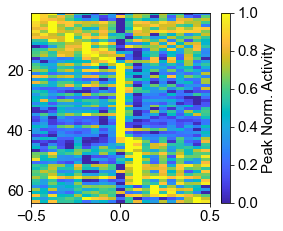

In [30]:
fig, ax_va = plt.subplots(figsize=heatmap_sz)
im = ax_va.imshow(utils.norm_within_feat(pes_cuep_vabinned)[utils.sort_by_max_loc(pes_cuep_vabinned), :],
             aspect='auto', extent=[-0.5, 0.5, 64, 1], cmap=utils.parula_map, interpolation='none')
ax_va.set_yticks([20, 40, 60])  # 32,
ax_va.set_yticklabels(['20', '40', '60'])
ax_va.spines['right'].set_visible(True)
ax_va.spines['top'].set_visible(True)

ax_pos.set_ylabel('Sensory PE');
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')



### Figure 6C: Position responses

In [17]:
SF_cuep_mat = np.dstack([pes_i[:CUEP_LIM, :] for pes_i in SF_]).T
norm_pes = utils.norm_within_feat(np.nanmean(SF_cuep_mat, 0))
# *SLOPE* sorted position from matlab withonly position sensitive units
# from matlab script: timelock_to_pos.m
# savemat(load_prefix + 'norm_pos_SF.mat',
#         {'norm_pes': norm_pes, 'num_steps_xticks': ypos_cuep})


norm_pes_pos = loadmat(load_prefix + 'sorted_norm_pos_SF.mat')['norm_pes']
ypos_pes_pos = np.squeeze(
    loadmat(load_prefix + 'sorted_norm_pos_SF.mat')['num_steps_xticks'])
order = np.squeeze(
    loadmat(load_prefix + 'sorted_norm_pos_SF.mat')['order_possen']) - 1


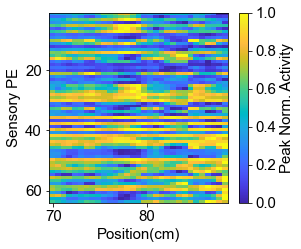

In [25]:

fig, ax_pos = plt.subplots(figsize=heatmap_sz)

im = ax_pos.imshow(norm_pes_pos[order, :], cmap=utils.parula_map,
              aspect='auto', interpolation='none', extent=[ypos_pes_pos[0], ypos_pes_pos[-1], 64, 1])

ax_pos.set_yticks([20, 40, 60]) # , 34
ax_pos.set_yticklabels(['20', '40', '60'])
ax_pos.spines['right'].set_visible(True)
ax_pos.spines['top'].set_visible(True)
ax_pos.set_xlabel('Position(cm)');
ax_pos.set_ylabel('Sensory PE');
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')

### Figure 6D: Left/Right Cue Responses

In [9]:
leftCue_ = [trialcue[0][0] - 2 for trialcue in cueOnset_]
rightCue_ = [trialcue[1][0] - 2 for trialcue in cueOnset_]


pes_lcue = utils.get_timelocked_cues(SF_, leftCue_)
pes_rcue = utils.get_timelocked_cues(SF_, rightCue_)

cue_savefile = 'SF_lcuercue_gamma99.mat'

# savemat(load_prefix + cue_savefile,
#         {'mrContra': np.nanmean(pes_lcue, 0).T, 'mrIpsi': np.nanmean(pes_rcue, 0).T})


In [10]:

norm_pes_lcue = loadmat(
    load_prefix + 'sorted_atcue_' + cue_savefile)['mrContra']
norm_pes_rcue = loadmat(load_prefix + 'sorted_atcue_' + cue_savefile)['mrIpsi']
sort_order = np.squeeze(
    loadmat(load_prefix + 'sorted_atcue_' + cue_savefile)['order']) - 1

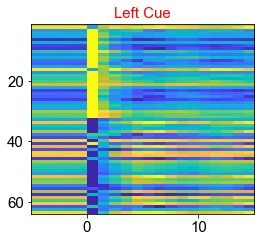

In [11]:

fig, left_ax = plt.subplots(figsize=heatmap_sz)
left_ax.imshow(norm_pes_lcue[sort_order, :-10], aspect='auto', extent=[-5, 15, 64, 1],
               cmap=utils.parula_map, interpolation='none')  # ,vmin = vmin, vmax = vmax)
left_ax.set_title('Left Cue', color=left_col, fontsize=15)
# left_ax.set_xlabel('Time steps from Cue Onset')
# left_ax.set_ylabel('Vector RPEs', fontsize = FONT_BG)
left_ax.set_yticks([20, 40, 60])  # EX_UNIT_LEFT_IDX,
left_ax.set_yticklabels(['20', '40', '60'])
left_ax.set_xticks([0, 10])

left_ax.spines['right'].set_visible(True)
left_ax.spines['top'].set_visible(True)
# left_ax.tick_params(direction="in", length=10)

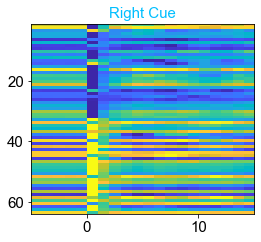

In [12]:

fig, right_ax = plt.subplots(figsize=heatmap_sz)
plot_for_cbar = right_ax.imshow(norm_pes_rcue[sort_order, :-10], aspect='auto', extent=[-5, 15, 64, 1],
                                cmap=utils.parula_map, interpolation='none')  # , vmin = vmin, vmax = vmax)
right_ax.set_title('Right Cue', color=right_col, fontsize=15)
right_ax.spines['right'].set_visible(True)
right_ax.spines['top'].set_visible(True)
right_ax.set_yticks([20, 40, 60])  # EX_UNIT_RIGHT_IDX,
right_ax.set_yticklabels(['20', '40', '60'])
right_ax.set_xticks([0, 10])


### Figure 6E: Confirm/Disconfirm responses

In [10]:
diff_ = [np.roll(tow_tr[:, 0] - tow_tr[:, 1], 1) for tow_tr in tow_counts_]

leftCue_confirm = [diff_tr[leftCue_[i]] for (i, diff_tr) in enumerate(diff_)]
rightCue_confirm = [diff_tr[rightCue_[i]] for (i, diff_tr) in enumerate(diff_)]

# cues: confirmatory and disconfirmatory
confirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] > 0], *(rightCue_[i])
                       [rightCue_confirm[i] < 0]]) for i in np.arange(len(leftCue_))]
dConfirmCue_ = [np.sort([*(leftCue_[i])[leftCue_confirm[i] < 0], *(rightCue_[i])
                        [rightCue_confirm[i] > 0]]) for i in np.arange(len(leftCue_))]


pes_Ccue = utils.get_timelocked_cues(SF_, confirmCue_)
pes_DCcue = utils.get_timelocked_cues(SF_, dConfirmCue_)


In [11]:
sort_order = np.squeeze(
    loadmat(load_prefix + 'sorted_atcue_SF_lcuercue_gamma99.mat')['order']) - 1


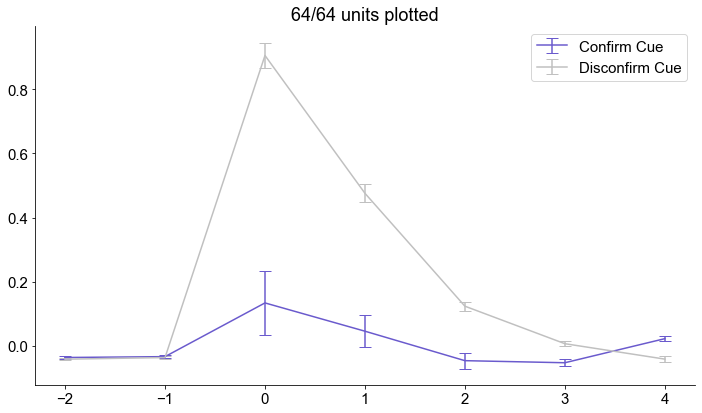

In [14]:
timesteps = np.arange(-2, 5)
timesteps_idx = timesteps + 5

units = np.arange(64)
marker_plots_big = {'marker': '.', 'markersize': 5,
                    'markeredgecolor': 'k', 'markerfacecolor': 'k'}

fig = plt.figure(figsize=(10, 6))
scalar_ax = plt.gca()

scalar_ax.errorbar(timesteps, np.nanmean(np.nanmean(pes_Ccue, 0)[:, units], -1)[timesteps_idx],
                   yerr=np.nanstd(np.nanmean(pes_Ccue, 0)[
                                  :, units], -1)[timesteps_idx]/(len(units) - 1),
                   label='Confirm Cue', color='slateblue', capsize=6)
scalar_ax.errorbar(timesteps, np.nanmean(np.nanmean(pes_DCcue, 0)[:, units], -1)[timesteps_idx],
                   yerr=np.nanstd(np.nanmean(pes_DCcue, 0)[
                                  :, units], -1)[timesteps_idx]/(len(units) - 1),
                   label='Disconfirm Cue', color='silver', capsize=6)


plt.title(str(len(units)) + '/64 units plotted')
scalar_ax.spines['top'].set_visible(False)
scalar_ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.legend()

### Figure 6f-6j: Outcome period plots

In [15]:
SF_rewp = np.dstack([pes_i[rew_idx - 5:rew_idx + 6, :]
                    for [pes_i, rew_idx] in zip(SF_, ep_rewidx)])
num_trials = len(ep_tow)
SF_rewp_norm = utils.norm_within_feat(SF_rewp.transpose((1, 0, 2)).reshape(
    64, 11 * num_trials)).reshape(64, 11, num_trials).transpose(1, 0, 2)


rew_trials = np.where(ep_rew == 1)[0]
nrew_trials = np.where(ep_rew == 0)[0]
easy_trials = np.hstack(ep_towdelt_idx[5:])
hard_trials = np.hstack(ep_towdelt_idx[:2])

rew_hard = np.sort(list(set(rew_trials) & set(hard_trials)))
rew_easy = np.sort(list(set(rew_trials) & set(easy_trials)))


WilcoxonResult(statistic=960.0, pvalue=0.5926495971646389)

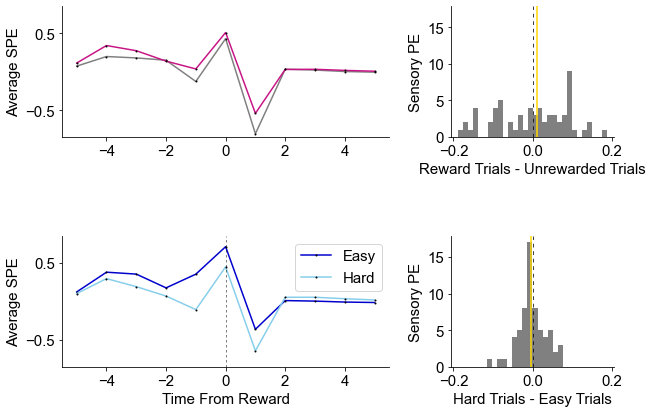

In [20]:

fig = plt.figure(figsize=(9, 6))
SF_to_plot = SF_rewp
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
# easy vs hard

ax_sum_rew = plt.subplot(gs[0, 0])

ax_sum_rew.plot(np.arange(-5, 6), np.mean(np.nanmean(SF_to_plot[:, :, nrew_trials], -1), -1),
                **marker_plots,  color='gray', label='unrew trials')
ax_sum_rew.plot(np.arange(-5, 6), np.mean(np.nanmean(SF_to_plot[:, :, rew_trials], -1), -1),
                **marker_plots,  color='mediumvioletred', label='rew trials')

# rew_act = np.nanmean(SF_to_plot[:, :, rew_trials], -1)
# nrew_act = np.nanmean(SF_to_plot[:, :, nrew_trials], -1)
# ax_sum_rew.errorbar(np.arange(-5, 6), np.mean(nrew_act, -1), yerr=np.std(nrew_act, -1)/np.sqrt(63),
#                     **marker_plots, color='gray', label='unrew trials')
# ax_sum_rew.errorbar(np.arange(-5, 6), np.mean(rew_act, -1), yerr=np.std(rew_act, -1)/np.sqrt(63),
#                     **marker_plots, color='mediumvioletred', label='rew trials')


ax_sum_rew.set_ylim(-0.85, 0.85)
ax_sum_rew.set_yticks((-0.5, 0.5))
# ax_sum_rew.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)

ax_sum_rew.set_ylabel('Average SPE')
# ax_sum.legend()


ax_hist_rew = plt.subplot(gs[0, 1])
norm_nrew = (np.mean(SF_rewp_norm[:, :, nrew_trials], -1).T)[:, 5]
norm_rew = (np.mean(SF_rewp_norm[:, :, rew_trials], -1).T)[:, 5]

_, uniform_bins, _ = ax_hist_rew.hist(norm_rew - norm_nrew, color='grey',
                                      bins=30)  # different bins to make the bins look the same width
ax_hist_rew.axvline(np.median(norm_rew - norm_nrew), color='gold')
ax_hist_rew.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)

ax_hist_rew.set_xlabel('Reward Trials - Unrewarded Trials')
ax_hist_rew.set_ylabel('Sensory PE')


ax_sum_rewexp = plt.subplot(gs[1, 0])

ax_sum_rewexp.plot(np.arange(-5, 6), np.nanmean(np.nanmean(SF_to_plot[:, :, rew_easy], -1), -1),
                   **marker_plots, color='mediumblue', label='Easy')

ax_sum_rewexp.plot(np.arange(-5, 6), np.nanmean(np.nanmean(SF_to_plot[:, :, rew_hard], -1), -1),
                   **marker_plots, color='skyblue', label='Hard')



ax_sum_rewexp.set_ylim(-0.85, 0.85)
ax_sum_rewexp.set_yticks((-0.5, 0.5))
ax_sum_rewexp.axvline(0, color='k', lw=0.5, ls=(0, (5, 5)))

ax_sum_rewexp.legend()
ax_sum_rewexp.set_ylabel('Average SPE')
ax_sum_rewexp.set_xlabel('Time From Reward')


norm_easy = (np.mean(SF_rewp_norm[:, :, rew_easy], -1).T)[:, 5]
norm_hard = (np.mean(SF_rewp_norm[:, :, rew_hard], -1).T)[:, 5]


ax_hist_rewexp = plt.subplot(gs[1, 1])
ax_hist_rewexp.hist(norm_hard - norm_easy, color='grey', bins=15)
ax_hist_rewexp.axvline(np.median(norm_hard - norm_easy), color='gold')
ax_hist_rewexp.axvline(0,  ls=(0, (5, 5)), color='k', lw=0.75)
ax_hist_rewexp.set_xlim(ax_hist_rew.get_xlim())
np.median(norm_hard - norm_easy)

ax_hist_rewexp.set_xlabel('Hard Trials - Easy Trials')
ax_hist_rewexp.set_ylabel('Sensory PE')
ax_hist_rew.set_ylim(ax_hist_rewexp.get_ylim())

plt.tight_layout(w_pad=1.3, h_pad=4)


stats.wilcoxon(norm_rew - norm_nrew)
stats.wilcoxon(norm_hard - norm_easy)
